In [1]:
import ray
ray.shutdown()
ray.init(num_cpus=3)

debug = False
CMDP_type = "streaming"  # choose "random" or "streaming"
# NUM_SEEDS = 30
NUM_SEEDS = 3

record_resol = 100  # regret is recorded every 100 steps

2025-08-02 10:17:16,390	INFO worker.py:1888 -- Started a local Ray instance.


In [2]:
from envs.cmdp import CMDP
from envs.tabular import create_cmdp

In [4]:
# Hyperparameters

if CMDP_type == "random":
    Cr_coef = 0.1
    Cu_coef = 0.05
    Cd_coef = 0.1
    Clam_coef = 100
    ENT_COEF = 0.1

elif CMDP_type == "streaming":
    Cr_coef = 10
    Cu_coef = 5
    Cd_coef = 10
    Clam_coef = 100
    ENT_COEF = 0.1

# Proposed Algorithm (Algorithm 2)

In [76]:
from functools import partial
import jax
import chex
from tqdm import tqdm


@jax.jit
def update(_, args):
    args1, args2 = args
    regret, vio_regret, safe_deploy_sum = args1
    key, pol, cmdp, Lambda_inv, ephi_sum = args2

    # hyperparameters
    Cr = Cr_coef * d * H
    Cu = Cu_coef * d * H
    Cd = Cd_coef * d ** 2 * H ** 3 / cmdp.xi
    # Bd = 0.1 * d * H ** 2 / cmdp.xi
    Bd = 1
    Clam = Clam_coef * d * H ** 4 / (cmdp.xi ** 2)
    ent_coef = ENT_COEF

    key, traj, err_rew, err_vio = sample_and_compute_regret(key, cmdp, pol)
    err_vio = jnp.maximum(err_vio, 0)

    # ===== compute bonus function =====
    Phi = cmdp.phi[traj[:, 0]]  # (H x d)
    Lambda_inv = Sherman_Morrison_update_H(Lambda_inv, Phi)
    phi_Lambda_inv = jnp.einsum('kd,hde->hke', cmdp.phi, Lambda_inv)
    chex.assert_shape(phi_Lambda_inv, (H, S*A, d))
    bonus = jnp.einsum('hkd,kd->hk', phi_Lambda_inv, cmdp.phi).reshape(H, S, A)
    # bonus = jnp.sqrt(jnp.maximum(bonus, 0))  # the maximum is to avoid numerical issues

    # ===== compute estimated P =====
    @jax.vmap
    def update_ephi_sum(ephi_sum, traj):
        sa, ns = traj
        ephi_sum = ephi_sum.at[ns].add(cmdp.phi[sa])
        return ephi_sum

    ephi_sum = update_ephi_sum(ephi_sum, traj)
    mu = ephi_sum @ Lambda_inv
    chex.assert_shape(mu, (H, S, d))
    est_P = jnp.einsum('hsd,kd->hks', mu, cmdp.phi).reshape(H, S, A, S)

    # ===== search sufficiently small lambda =====
    est_cmdp = cmdp._replace(P=est_P)

    def body_fn(_, lam_range):
        lam_low, lam_high = lam_range
        mid_lam = (lam_low + lam_high) / 2
        util, _ = compute_softmax_pol(bonus, est_cmdp, ent_coef, mid_lam, Cr, Cd, Cu, Bd)
        is_util_safe = util >= cmdp.const
        next_lam_range = jax.lax.cond(
            is_util_safe,
            lambda: jnp.array((lam_low, mid_lam)),
            lambda: jnp.array((mid_lam, lam_high))
        )
        return next_lam_range

    lam_range = jax.lax.fori_loop(0, 20, body_fn, jnp.array((0.0, Clam), dtype=jnp.float32))
    _, pol = compute_softmax_pol(bonus, est_cmdp, ent_coef, lam_range[1], Cr, Cd, Cu, Bd)
    # pol = jax.lax.cond(lam_range[1] == Clam, lambda: cmdp.safe_policy, lambda: pol)

    is_safe_deployed = lam_range[1] == Clam

    regret = regret + err_rew
    vio_regret = vio_regret + err_vio
    safe_deploy_sum = safe_deploy_sum + is_safe_deployed
    return (regret, vio_regret, safe_deploy_sum), (key, pol, cmdp, Lambda_inv, ephi_sum)


@jax.jit
def multiple_updates(args):
    return jax.lax.fori_loop(0, record_resol, update, args)


def RunAlgo(cmdp: CMDP, iteration: int, seed):
    key = PRNGKey(seed)

    Lambda = jnp.tile(jnp.eye(d), (H, 1, 1))  # H x d x d
    Lambda_inv = jax.vmap(jnp.linalg.pinv)(Lambda)  # H x d x d
    ephi_sum = jnp.zeros((H, S, d))

    episodes = []
    regrets = []
    vio_regrets = []
    safe_deploy_sums = []

    pol = cmdp.safe_policy
    args = (0, 0, 0), (key, pol, cmdp, Lambda_inv, ephi_sum)
    epi_sum = 0

    # Record the initial results
    for _ in tqdm(range(record_resol)):
        args = update(0, args)
        (regret, vio_regret, safe_deploy_sum), _ = args
        epi_sum += 1
        episodes.append(epi_sum)
        regrets.append(regret)
        vio_regrets.append(vio_regret)
        safe_deploy_sums.append(safe_deploy_sum)

    for _ in tqdm(range(int(iteration / record_resol))):
        args = multiple_updates(args)
        (regret, vio_regret, safe_deploy_sum), _ = args

        epi_sum += record_resol
        episodes.append(epi_sum)
        regrets.append(regret)
        vio_regrets.append(vio_regret)
        safe_deploy_sums.append(safe_deploy_sum)
    return np.array(episodes), np.array(regrets), np.array(vio_regrets), np.array(safe_deploy_sums)

In [77]:
if debug:
    key = PRNGKey(1)

    cmdp = create_cmdp(key)
    cmdp = set_cmdp_info(cmdp)
    Lambda = jnp.tile(jnp.eye(d), (H, 1, 1))  # H x d x d
    Lambda_inv = jax.vmap(jnp.linalg.pinv)(Lambda)  # H x d x d
    ephi_sum = jnp.zeros((H, S, d))

    episodes = []
    regrets = []
    vio_regrets = []
    safe_deploy_sums = []

    pol = cmdp.safe_policy
    args = (0, 0, 0), (key, pol, cmdp, Lambda_inv, ephi_sum)
    epi_sum = 0

    for _ in tqdm(range(int(10000))):
        args = multiple_updates(args)
        (regret, vio_regret, safe_deploy_sum), _ = args

        regrets.append(regret)
        vio_regrets.append(vio_regret)
        safe_deploy_sums.append(safe_deploy_sum)

    vio_regrets[-1]

In [78]:
if debug:
    _, (key, pol, cmdp, Lambda_inv, ephi_sum) = args

    mu = ephi_sum @ Lambda_inv
    est_P = jnp.einsum('hsd,kd->hks', mu, cmdp.phi).reshape(H, S, A, S)
    print("est error", jnp.abs(est_P - cmdp.P)[1:].max())

    phi_Lambda_inv = jnp.einsum('kd,hde->hke', cmdp.phi, Lambda_inv)
    chex.assert_shape(phi_Lambda_inv, (H, S*A, d))
    bonus = jnp.einsum('hkd,kd->hk', phi_Lambda_inv, cmdp.phi).reshape(H, S, A)
    bonus = jnp.sqrt(jnp.maximum(bonus, 0))  # the maximum is to avoid numerical issues
    print("bonus", bonus[1:].max())


    # ===== search sufficiently small lambda =====
    Cr = 1.0
    Cu = 100
    Cd = 6
    # Bd = 0.1 * d * H ** 2 / cmdp.xi
    Bd = 1
    Clam = Clam_coef * d * H ** 4 / (cmdp.xi ** 2)
    ent_coef = 0.01


    est_cmdp = cmdp._replace(P=est_P)

    def body_fn(_, lam_range):
        lam_low, lam_high = lam_range
        mid_lam = (lam_low + lam_high) / 2
        util, _ = compute_softmax_pol(bonus, est_cmdp, ent_coef, mid_lam, Cr, Cd, Cu, Bd)
        is_util_safe = util >= cmdp.const
        next_lam_range = jax.lax.cond(
            is_util_safe,
            lambda: jnp.array((lam_low, mid_lam)),
            lambda: jnp.array((mid_lam, lam_high))
        )
        return next_lam_range

    print("parameters", Cr, Cu, Cd, Bd)
    lam_range = jax.lax.fori_loop(0, 30, body_fn, jnp.array((0.0, Clam), dtype=jnp.float32))
    util_est, pol = compute_softmax_pol(bonus, est_cmdp, ent_coef, lam_range[1], Cr, Cd, Cu, Bd)
    pol = jax.lax.cond(lam_range[1] == Clam, lambda: cmdp.safe_policy, lambda: pol)
    print("est safe", util_est - cmdp.const)

    _, _, err_rew, err_vio = sample_and_compute_regret(key, cmdp, pol)
    print("exact vio", err_vio)
    print("exact reg", err_rew)

In [79]:
if debug:
    est_cmdp = cmdp

    def body_fn(_, lam_range):
        lam_low, lam_high = lam_range
        mid_lam = (lam_low + lam_high) / 2
        util, _ = compute_softmax_pol(bonus, est_cmdp, ent_coef, mid_lam, Cr, Cd, Cu, Bd)
        is_util_safe = util >= cmdp.const
        next_lam_range = jax.lax.cond(
            is_util_safe,
            lambda: jnp.array((lam_low, mid_lam)),
            lambda: jnp.array((mid_lam, lam_high))
        )
        return next_lam_range

    print(Cr, Cu, Cd, Bd)
    lam_range = jax.lax.fori_loop(0, 20, body_fn, jnp.array((0.0, Clam), dtype=jnp.float32))
    util_est, pol = compute_softmax_pol(bonus, est_cmdp, ent_coef, lam_range[1], Cr, Cd, Cu, Bd)
    pol = jax.lax.cond(lam_range[1] == Clam, lambda: cmdp.safe_policy, lambda: pol)
    print(util_est - cmdp.const)

    _, _, err_rew, err_vio = sample_and_compute_regret(key, cmdp, pol)
    print(err_rew, err_vio)

In [80]:
if debug:
    Lambda = jnp.tile(jnp.eye(d), (H, 1, 1))  # H x d x d
    Lambda_inv = jax.vmap(jnp.linalg.pinv)(Lambda)  # H x d x d
    ephi_sum = jnp.zeros((H, S, d))

    pol = cmdp.safe_policy
    args = (0, 0, 0), (key, pol, cmdp, Lambda_inv, ephi_sum)
    epi_sum = 0

    for _ in tqdm(range(int(1000))):
        args = multiple_updates(args)
        (regret, vio_regret, safe_deploy_sum), (key, pol, cmdp, Lambda_inv, ephi_sum) = args
        phi_Lambda_inv = jnp.einsum('kd,hde->hke', cmdp.phi, Lambda_inv)
        chex.assert_shape(phi_Lambda_inv, (H, S*A, d))
        bonus = jnp.einsum('hkd,kd->hk', phi_Lambda_inv, cmdp.phi).reshape(H, S, A)
        # print(bonus[1:].min(), bonus[1:].max())

        mu = ephi_sum @ Lambda_inv
        est_P = jnp.einsum('hsd,kd->hks', mu, cmdp.phi).reshape(H, S, A, S)
        error_P = jnp.abs(est_P[1:] - cmdp.P[1:]).mean()
        print(error_P)

        # print(Lambda_inv.min(), Lambda_inv.max())
 

In [81]:
if debug:
    est_cmdp = cmdp._replace(P=est_P)

    def body_fn(_, lam_range):
        lam_low, lam_high = lam_range
        mid_lam = (lam_low + lam_high) / 2
        util, _ = compute_softmax_pol(jnp.zeros_like(bonus), est_cmdp, ent_coef, mid_lam, 0, 0, 0, 0)
        is_util_safe = util >= cmdp.const
        next_lam_range = jax.lax.cond(
            is_util_safe,
            lambda: jnp.array((lam_low, mid_lam)),
            lambda: jnp.array((mid_lam, lam_high))
        )
        return next_lam_range


    lam_range = jnp.array((0.0, Clam))
    for i in range(30):
        lam_range = body_fn(i, lam_range)
    util, pol = compute_softmax_pol(jnp.zeros_like(bonus), est_cmdp, ent_coef, lam_range[1], 0, 0, 0, 0)
    print(util- cmdp.const)

# Ghosh[2024]'s Algorithm

In [82]:

@jax.jit
def compute_softmax_pol_h_Ghosh(rQ_h, uQ_h, ent_coef, lam):
    Q_h = rQ_h + lam * uQ_h
    return jax.nn.softmax(Q_h / ent_coef, axis=-1)


@jax.jit
def compute_softmax_pol_Ghosh(bonus: jnp.ndarray, cmdp: CMDP, ent_coef: float, lam: float, Cr: float, Cu: float) -> jnp.ndarray:
    def backup(i, args):
        rQ, uQ, pol = args
        h = H - i - 1

        thresh = H - h
        rQ_h = compute_Q_h(rQ[h+1], pol[h+1], Cr * bonus[h], cmdp.rew[h], cmdp.P[h], 0, thresh)
        uQ_h = compute_Q_h(uQ[h+1], pol[h+1], Cu * bonus[h], cmdp.utility[h], cmdp.P[h], 0, thresh)
        pol_h = compute_softmax_pol_h_Ghosh(rQ_h, uQ_h, ent_coef, lam)

        rQ = rQ.at[h].set(rQ_h)
        uQ = uQ.at[h].set(uQ_h)
        pol = pol.at[h].set(pol_h)
        return rQ, uQ, pol

    rQ = jnp.zeros((H+1, S, A))
    uQ = jnp.zeros((H+1, S, A))
    pol = jnp.ones((H+1, S, A)) / A

    args = rQ, uQ, pol
    rQ, uQ, pol = jax.lax.fori_loop(0, H, backup, args)

    uV = jnp.sum(uQ * pol, axis=-1)
    total_util = cmdp.init_dist @ uV[0]
    return total_util, pol[:-1]


@jax.jit
def update_Ghosh(k, args):
    args1, args2 = args
    regret, vio_regret = args1
    key, pol, cmdp, Lambda_inv, ephi_sum = args2

    # hyperparameters
    Cr = Cr_coef * d * H
    Cu = Cu_coef * d * H
    ent_coef = ENT_COEF

    key, traj, err_rew, err_vio = sample_and_compute_regret(key, cmdp, pol)
    err_vio = jnp.maximum(err_vio, 0)

    # ===== compute bonus function =====
    Phi = cmdp.phi[traj[:, 0]]  # (H x d)
    Lambda_inv = Sherman_Morrison_update_H(Lambda_inv, Phi)
    phi_Lambda_inv = jnp.einsum('kd,hde->hke', cmdp.phi, Lambda_inv)
    chex.assert_shape(phi_Lambda_inv, (H, S*A, d))
    bonus = jnp.einsum('hkd,kd->hk', phi_Lambda_inv, cmdp.phi).reshape(H, S, A)
    # bonus = jnp.sqrt(bonus)  # the maximum is to avoid numerical issues

    # ===== compute estimated P =====
    @jax.vmap
    def update_ephi_sum(ephi_sum, traj):
        sa, ns = traj
        ephi_sum = ephi_sum.at[ns].add(cmdp.phi[sa])
        return ephi_sum

    ephi_sum = update_ephi_sum(ephi_sum, traj)
    mu = ephi_sum @ Lambda_inv
    chex.assert_shape(mu, (H, S, d))

    est_P = jnp.einsum('hsd,kd->hks', mu, cmdp.phi).reshape(H, S, A, S)

    # ===== search sufficiently small lambda =====
    est_cmdp = cmdp._replace(P=est_P)

    def body_fn(_, lam_range):
        lam_low, lam_high = lam_range
        mid_lam = (lam_low + lam_high) / 2
        util, _ = compute_softmax_pol_Ghosh(bonus, est_cmdp, ent_coef, mid_lam, Cr, Cu)
        is_util_safe = util >= cmdp.const
        next_lam_range = jax.lax.cond(
            is_util_safe,
            lambda: jnp.array((lam_low, mid_lam)),
            lambda: jnp.array((mid_lam, lam_high))
        )
        return next_lam_range

    lam_range = jax.lax.fori_loop(0, 20, body_fn, jnp.array((0.0, jnp.sqrt(K)), dtype=jnp.float32))
    _, pol = compute_softmax_pol_Ghosh(bonus, est_cmdp, ent_coef, lam_range[1], Cr, Cu)

    regret = regret + err_rew
    vio_regret = vio_regret + err_vio
    return (regret, vio_regret), (key, pol, cmdp, Lambda_inv, ephi_sum)


@jax.jit
def multiple_updates_Ghosh(args):
    return jax.lax.fori_loop(0, record_resol, update_Ghosh, args)


def RunAlgoGhosh(cmdp: CMDP, iteration: int, seed):
    key = PRNGKey(seed)

    Lambda = jnp.tile(jnp.eye(d), (H, 1, 1))  # H x d x d
    Lambda_inv = jax.vmap(jnp.linalg.pinv)(Lambda)  # H x d x d
    ephi_sum = jnp.zeros((H, S, d))

    episodes = []
    regrets = []
    vio_regrets = []

    pol = cmdp.safe_policy

    args = (0.0, 0.0), (key, pol, cmdp, Lambda_inv, ephi_sum)
    epi_sum = 0

    # Record the initial results
    for _ in tqdm(range(record_resol)):
        args = update_Ghosh(0, args)
        (regret, vio_regret), _ = args
        epi_sum += 1
        episodes.append(epi_sum)
        regrets.append(regret)
        vio_regrets.append(vio_regret)

    for _ in tqdm(range(int(iteration / record_resol))):
        args = multiple_updates_Ghosh(args)
        (regret, vio_regret), _ = args

        epi_sum += record_resol
        episodes.append(epi_sum)
        regrets.append(regret)
        vio_regrets.append(vio_regret)
    return np.array(episodes), np.array(regrets), np.array(vio_regrets)

# Uniform policy

In [83]:
def RunUniPolicy(cmdp: CMDP, iteration: int, seed):

    pol = jnp.ones((H, S, A)) / A
    key = PRNGKey(seed)  # dummy. computing temporal regret does not require randomness here.
    key, _, err_rew, err_vio = sample_and_compute_regret(key, cmdp, pol)

    errors_rew = [err_rew] * int(iteration / record_resol)
    regrets = np.cumsum(errors_rew) * record_resol
    errors_vio = [np.maximum(err_vio, 0)] * int(iteration / record_resol)
    vio_regrets = np.cumsum(errors_vio) * record_resol
    episodes = np.arange(int(iteration / record_resol)) * record_resol + 1
    return np.array(episodes), np.array(regrets), np.array(vio_regrets)

In [84]:
if debug:
    _K = 10000
    key = PRNGKey(0)
    cmdp = create_cmdp(key)
    cmdp = set_cmdp_info(cmdp)

    episodes, regrets, vio_regrets, safe_deploy_sums, errors_P = RunAlgo(cmdp, K, 0)
    # RunAlgoGhosh(cmdp, _K, 0)
    # RunUniPolicy(cmdp, _K, 0)

# Run Algorithms

In [85]:
import ray


@ray.remote
class Buffer:
    def __init__(self):
        self.episodes = []
        self.regrets = []
        self.vio_regrets = []
        self.safe_deploy_sums = []

        self.episodes_Ghosh = []
        self.regrets_Ghosh = []
        self.vio_regrets_Ghosh = []

        self.episodes_uni = []
        self.regrets_uni = []
        self.vio_regrets_uni = []

    def add_proposal(self, episodes, regrets, vio_regrets, safe_deploy_sums):
        self.episodes.append(episodes)
        self.regrets.append(regrets)
        self.vio_regrets.append(vio_regrets)
        self.safe_deploy_sums.append(safe_deploy_sums)

    def add_Ghosh(self, episodes_Ghosh, regrets_Ghosh, vio_regrets_Ghosh):
        self.episodes_Ghosh.append(episodes_Ghosh)
        self.regrets_Ghosh.append(regrets_Ghosh)
        self.vio_regrets_Ghosh.append(vio_regrets_Ghosh)

    def add_uni(self, episodes_uni, regrets_uni, vio_regrets_uni):
        self.episodes_uni.append(episodes_uni)
        self.regrets_uni.append(regrets_uni)
        self.vio_regrets_uni.append(vio_regrets_uni)

    def get(self):
        episodes = np.array(self.episodes)
        regrets = np.array(self.regrets)
        vio_regrets = np.array(self.vio_regrets)
        deploy_sums = np.array(self.safe_deploy_sums)

        Ghosh_episodes = np.array(self.episodes_Ghosh)
        Ghosh_regrets = np.array(self.regrets_Ghosh)
        Ghosh_vio_regrets = np.array(self.vio_regrets_Ghosh)

        uni_episodes = np.array(self.episodes_uni)
        uni_regrets = np.array(self.regrets_uni)
        uni_vio_regrets = np.array(self.vio_regrets_uni)

        return episodes, regrets, vio_regrets, deploy_sums, Ghosh_episodes, Ghosh_regrets, Ghosh_vio_regrets, uni_episodes, uni_regrets, uni_vio_regrets


@ray.remote
def run_proposal(buffer, seed):
    key = PRNGKey(seed)
    cmdp = create_cmdp(key)
    cmdp = set_cmdp_info(cmdp)

    episodes, regrets, vio_regrets, safe_deploy_sums = RunAlgo(cmdp, K, seed)

    buffer.add_proposal.remote(
        np.array(episodes),
        np.array(regrets),
        np.array(vio_regrets),
        np.array(safe_deploy_sums),
    )


@ray.remote
def run_Ghosh(buffer, seed):
    key = PRNGKey(seed)
    cmdp = create_cmdp(key)
    cmdp = set_cmdp_info(cmdp)

    episodes_Ghosh, regrets_Ghosh, vio_regrets_Ghosh = RunAlgoGhosh(cmdp, K, seed)

    buffer.add_Ghosh.remote(
        np.array(episodes_Ghosh),
        np.array(regrets_Ghosh),
        np.array(vio_regrets_Ghosh),
    )


@ray.remote
def run_uni(buffer, seed):
    key = PRNGKey(seed)
    cmdp = create_cmdp(key)
    cmdp = set_cmdp_info(cmdp)

    episodes_uni, regrets_uni, vio_regrets_uni = RunUniPolicy(cmdp, K, seed)

    buffer.add_uni.remote(
        np.array(episodes_uni),
        np.array(regrets_uni),
        np.array(vio_regrets_uni)
    )


buffer = Buffer.remote()

jobs = []
for i in range(NUM_SEEDS):
    jobs.append(run_proposal.remote(buffer, i))
    jobs.append(run_Ghosh.remote(buffer, i))
    jobs.append(run_uni.remote(buffer, i))

_ = ray.get(jobs)

In [86]:
import pickle

with open(f"results-{CMDP_type}.pkl", "wb") as f:
    results = ray.get(buffer.get.remote())
    pickle.dump(results, f)

In [87]:
import pickle
with open(f"results-{CMDP_type}.pkl", "rb") as f:
    results = pickle.load(f)
    episodes, regrets, vio_regrets, deploy_sums, Ghosh_episodes, Ghosh_regrets, Ghosh_vio_regrets, uni_episodes, uni_regrets, uni_vio_regrets = results

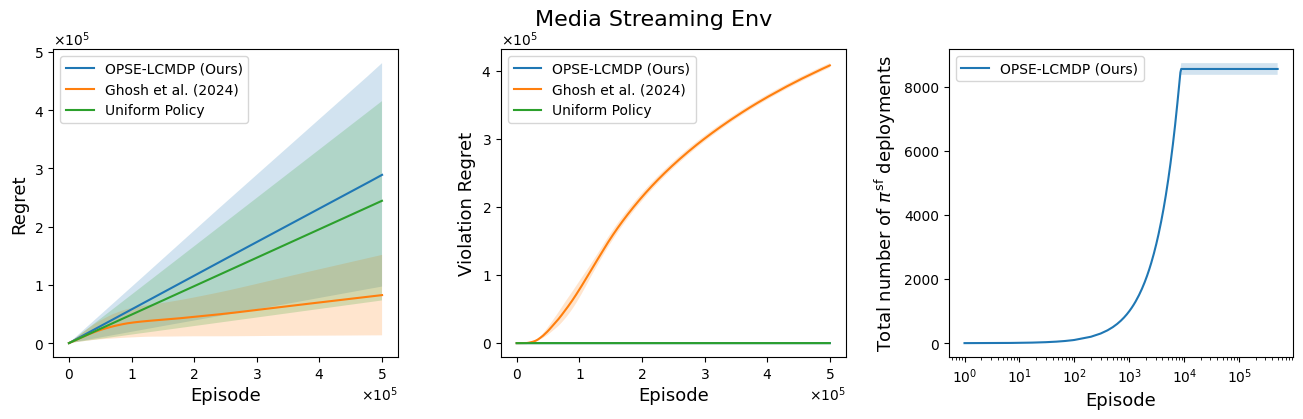

In [88]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter


class FixedOrderFormatter(ScalarFormatter):
    def __init__(self, order_of_mag=0, useOffset=True, useMathText=True):
        self._order_of_mag = order_of_mag
        ScalarFormatter.__init__(self, useOffset=useOffset, 
                                 useMathText=useMathText)
    def _set_orderOfMagnitude(self, range):
        self.orderOfMagnitude = self._order_of_mag


# Compute mean and std
epi_mean = episodes.mean(axis=0)
reg_mean, reg_std = regrets.mean(axis=0), regrets.std(axis=0)
vio_mean, vio_std = vio_regrets.mean(axis=0), vio_regrets.std(axis=0)
deploy_mean, deploy_std = deploy_sums.mean(axis=0), deploy_sums.std(axis=0)

Ghosh_epi_mean = Ghosh_episodes.mean(axis=0)
Ghosh_reg_mean, Ghosh_reg_std = Ghosh_regrets.mean(axis=0), Ghosh_regrets.std(axis=0)
Ghosh_vio_mean, Ghosh_vio_std = Ghosh_vio_regrets.mean(axis=0), Ghosh_vio_regrets.std(axis=0)

uni_epi_mean = uni_episodes.mean(axis=0)
uni_reg_mean, uni_reg_std = uni_regrets.mean(axis=0), uni_regrets.std(axis=0)
uni_vio_mean, uni_vio_std = uni_vio_regrets.mean(axis=0), uni_vio_regrets.std(axis=0)


# Plot with std bars
fig = plt.figure(figsize=(16, 4))
fig.subplots_adjust(wspace=0.3)

# Plot cumulative reward
ax = fig.add_subplot(1, 3, 1)
ax.plot(epi_mean, reg_mean, label="OPSE-LCMDP (Ours)", rasterized=True)
ax.fill_between(epi_mean, reg_mean - reg_std, reg_mean + reg_std, alpha=0.2)
ax.plot(Ghosh_epi_mean, Ghosh_reg_mean, label="Ghosh et al. (2024)", rasterized=True)
ax.fill_between(Ghosh_epi_mean, Ghosh_reg_mean - Ghosh_reg_std, Ghosh_reg_mean + Ghosh_reg_std, alpha=0.2)
ax.plot(uni_epi_mean, uni_reg_mean, label="Uniform Policy", rasterized=True)
ax.fill_between(uni_epi_mean, uni_reg_mean - uni_reg_std, uni_reg_mean + uni_reg_std, alpha=0.2)

ax.set_ylabel("Regret", fontdict={"fontsize": 13})
ax.set_xlabel("Episode", fontdict={"fontsize": 13})
ax.legend()
ax.yaxis.set_major_formatter(FixedOrderFormatter(5 ,useMathText=True))
ax.xaxis.set_major_formatter(FixedOrderFormatter(5 ,useMathText=True))
ax.ticklabel_format(style="sci",  axis="y", scilimits=(0,0))
ax.ticklabel_format(style="sci",  axis="x", scilimits=(0,0))

# Plot cumulative violations
ax2 = fig.add_subplot(1, 3, 2)
ax2.plot(epi_mean, vio_mean, label="OPSE-LCMDP (Ours)", rasterized=True)
ax2.fill_between(epi_mean, vio_mean - vio_std, vio_mean + vio_std, alpha=0.2)
ax2.plot(Ghosh_epi_mean, Ghosh_vio_mean, label="Ghosh et al. (2024)", rasterized=True)
ax2.fill_between(Ghosh_epi_mean, Ghosh_vio_mean - Ghosh_vio_std, Ghosh_vio_mean + Ghosh_vio_std, alpha=0.2)
ax2.plot(uni_epi_mean, uni_vio_mean, label="Uniform Policy", rasterized=True)
ax2.fill_between(uni_epi_mean, uni_vio_mean - uni_vio_std, uni_vio_mean + uni_vio_std, alpha=0.2)
ax2.set_ylabel("Violation Regret", fontdict={"fontsize": 13})
ax2.set_xlabel("Episode", fontdict={"fontsize": 13})
ax2.legend()
ax2.yaxis.set_major_formatter(FixedOrderFormatter(6 ,useMathText=True))
ax2.xaxis.set_major_formatter(FixedOrderFormatter(5 ,useMathText=True))
ax2.ticklabel_format(style="sci",  axis="y", scilimits=(0,0))
ax2.ticklabel_format(style="sci",  axis="x", scilimits=(0,0))

# plot number of safe policy deployments
ax3 = fig.add_subplot(1, 3, 3)
ax3.plot(epi_mean, deploy_mean, label="OPSE-LCMDP (Ours)", rasterized=True)
ax3.fill_between(epi_mean, deploy_mean - deploy_std, deploy_mean + deploy_std, alpha=0.2)
ax3.set_ylabel(r"Total number of $\pi^{\mathrm{sf}}$ deployments", fontdict={"fontsize": 13})
ax3.set_xlabel("Episode", fontdict={"fontsize": 13})
ax3.set_xscale("log")
ax3.legend()

if CMDP_type == "random":
    plt.suptitle(f"Synthetic Tabular Env", fontsize=16)
elif CMDP_type == "streaming":
    plt.suptitle(f"Media Streaming Env", fontsize=16)
elif CMDP_type == "linear":
    plt.suptitle(f"Synthetic Linear Env", fontsize=16)

# plt.tight_layout()
plt.savefig(f"results-{CMDP_type}.pdf")